# 5.1 Future Success

In [1]:
from collections import defaultdict as dd
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
DIR_PREP = '../data/prepared/'
DIR_SAMPLE = '../data/samples/'
PATH_REVIEWS = DIR_PREP + 'reviews/%d.csv'
PATH_LANGS = DIR_PREP + 'reviews/languages/%d.csv'
PATH_REVUSERS = DIR_SAMPLE + 'review_users/%s.csv'
REVIEW_PAGES = 32
LANGS_PAGES = 21

In [3]:
def load_reviews():
    df = pd.concat((
        pd.read_csv(PATH_REVIEWS % page_num, header=None)
        for page_num in range(1, REVIEW_PAGES + 1)
    )).reset_index(drop=True)
    df.columns = [
        'uid','gid','polarity','ea','pt_forever','pt_review',
        'ts_created','ts_updated','votes_up','votes_funny','text'
    ]
    return df

def load_reviews_lang():
    df = pd.concat((
        pd.concat((
            pd.read_csv(PATH_REVIEWS % page_num, header=None),
            pd.read_csv(PATH_LANGS % page_num, header=None)
        ), axis=1)
        for page_num in range(1, LANGS_PAGES + 1)
    )).reset_index(drop=True)
    df.columns = [
        'uid','gid','polarity','ea','pt_forever','pt_review',
        'ts_created','ts_updated','votes_up','votes_funny','text',
        'lang','confidence','nlp_words','raw_words','raw_chars'
    ]
    return df

In [12]:
def filter_reviews(df, is_eng=True, min_game_reviews=50, min_user_reviews=10, min_conf=0.5):
    df = df[df['ea'] == 0]
    df = df[df['text'] != '(Review text hidden)']
    df = df[df['nlp_words'] >= 1]
    if is_eng: df = df[(df['lang'] == 'en') & (df['confidence'] >= min_conf)]
    df = df[df.groupby('gid')['gid'].transform('size') >= min_game_reviews]
    df = df[df.groupby('uid')['uid'].transform('size') >= min_user_reviews]
    return df

In [20]:
def mean_to_class_6(x):
    if x < 0.2: return 0
    elif x < 0.4: return 1
    elif x < 0.7: return 2
    elif x < 0.8: return 3
    elif x < 0.95: return 4
    else: return 5

def mean_to_class_3(x):
    if x < 0.4: return 0
    elif x < 0.7: return 1
    else: return 2

In [21]:
def prepare_data(df, sample_name, num_labels=7, N=100000, train_size=0.8, test_size=0.5, seed=None):
    df['gid_mean'] = df.groupby('gid')['polarity'].transform('mean')
    class_function = mean_to_class_6 if num_labels == 6 else mean_to_class_3
    df['gid_mean_class'] = df['gid_mean'].apply(class_function)
    uids = df['uid'].unique().tolist()
    random.seed(seed)
    random.shuffle(uids)
    uids = uids[:int(N / (len(df.index) / len(uids)))]
    train_uids, rem_uids = train_test_split(uids, train_size=train_size, random_state=seed)
    val_uids, test_uids = train_test_split(rem_uids, test_size=test_size, random_state=seed)
    df[df['uid'].isin(train_uids)][
        ['uid','gid','gid_mean','gid_mean_class','pt_review','text']].to_csv(
        PATH_REVUSERS % f'{sample_name}_{num_labels}_train', index=False)
    df[df['uid'].isin(val_uids)][[
        'uid','gid','gid_mean','gid_mean_class','pt_review','text']].to_csv(
        PATH_REVUSERS % f'{sample_name}_{num_labels}_val', index=False)
    df[df['uid'].isin(test_uids)][
        ['uid','gid','gid_mean','gid_mean_class','pt_review','text']].to_csv(
        PATH_REVUSERS % f'{sample_name}_{num_labels}_test', index=False)

In [7]:
df_lang = load_reviews_lang()

In [13]:
df_eng = filter_reviews(df_lang, is_eng=True)
df_neng = filter_reviews(df_lang, is_eng=False)

In [22]:
prepare_data(df_eng, 'eng_160k', num_labels=3, N=160000, seed=1337)
prepare_data(df_eng, 'eng_160k', num_labels=6, N=160000, seed=1337)
prepare_data(df_neng, 'any_160k', num_labels=3, N=160000, seed=1337)
prepare_data(df_neng, 'any_160k', num_labels=6, N=160000, seed=1337)

## Other Stuff

In [8]:
def set_months_after_release(df):
    month_seconds = 30 * 24 * 60 * 60
    df['gid_ts_min'] = df.groupby('gid')['ts_created'].transform('min')
    df['gid_months_after'] = 1 + ((df['ts_created'] - df['gid_ts_min']) // month_seconds)
    return df

In [9]:
df_filt = set_months_after_release(df_filt)

In [12]:
df_filt = df_filt[df_filt['gid_months_after'] <= 12]

In [58]:
df_counts = df_filt.groupby(['gid', 'gid_months_after', 'polarity']).agg(['count']).reset_index().values[:,:4].tolist()

In [65]:
gid_counts = {}
N = len(df_counts)
for i in range(N):
    g, m, p, c = df_counts[i]
    if g not in gid_counts:
        cnts = []
        for _ in range(12): cnts.append([0, 0])
        gid_counts[g] = cnts
    gid_counts[g][m - 1][p] += c

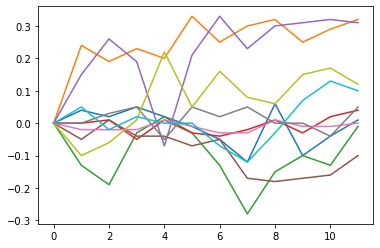

In [116]:
t=0
for gid, mcs in gid_counts.items():
    if all(sum(x) >= 10 for x in mcs):
        rs = [round(p/(n+p),2) for (n,p) in mcs]
        css = [[*mcs[0]]]
        for i in range(1, 12):
            css.append([css[-1][0] + mcs[i][0], css[-1][1] + mcs[i][1]])
        #rs = [round(p/(n+p),2) for (n,p) in css]
        #rs = [n+p for (n,p) in mcs]
        for i in range(1, 12): rs[i] -= rs[0]
        rs[0] = 0
        plt.plot(list(range(12)),rs)
        t+=1
        if t>=10: break
plt.show()

In [ ]:
# predicting change in rating
# >x% increase , >x% decrease, neither

In [127]:
df_filt['ts_datetime'] = df_filt['ts_created'].apply(dt.fromtimestamp)
df_filt['ts_year'] = df_filt['ts_datetime'].apply(lambda x: x.year)
df_filt['ts_month'] = df_filt['ts_datetime'].apply(lambda x: x.month)

In [129]:
df_filt = df_filt[['gid', 'ts_datetime', 'polarity']]
values = df_filt.values
N = len(values)

In [162]:
def select_first_months(df, max_months=12, min_monthly_revs=5):
    month_seconds = 30 * 24 * 60 * 60
    values = sorted(df[['gid', 'ts_created', 'polarity']].values.tolist())
    cur_gid, min_ts = -1, 0
    gid_counts = {}
    i, N = 0, len(values)
    while i < N:
        gid, ts, p = values[i]
        if gid != cur_gid:
            if cur_gid != -1:
                all_months_good = all(
                    sum(gid_counts[cur_gid][j]) >= min_monthly_revs
                    for j in range(max_months)
                )
                if not all_months_good:
                    del gid_counts[cur_gid]
            cur_gid = gid
            min_ts = ts
            counts = []
            for _ in range(max_months):
                counts.append([0, 0])
            gid_counts[gid] = counts
        num_months = (ts - min_ts) // month_seconds
        if num_months >= max_months:
            while cur_gid == values[i]:
                i += 1
        else:
            gid_counts[gid][num_months][p] += 1
            i += 1
    return gid_counts

In [ ]:
print(0)

In [69]:
grouped = dd(lambda: dd(lambda: [0, 0]))
for i in range(N):
    gid, y, m, p = values[i]
    grouped[gid][(y, m)][p] += 1

In [93]:
diffs = dd(list)
for gid, dates in grouped.items():
    cur_y, cur_m = min(dates.keys())
    max_y, max_m = max(dates.keys())
    monthly, average = [], []
    while cur_y < max_y or (cur_y == max_y and cur_m <= max_m):
        key = (cur_y, cur_m)
        if key not in dates:
            monthly.append([0, 0])
            average.append(average[-1])
        else:
            cnt_n, cnt_p = dates[key]
            monthly.append([cnt_n, cnt_p])
            if len(average) == 0: average.append([cnt_n, cnt_p])
            else: average.append([cnt_n + average[-1][0], cnt_p + average[-1][1]])
        cur_m += 1
        if cur_m > 12:
            cur_m = 1
            cur_y += 1
    running_rating = [p/(p+n) for n, p in average]
    monthly_rating = [0 if (p+n)==0 else p/(p+n) for n, p in monthly]
    #X = list(range(len(running_rating)))
    #plt.plot(X, running_rating)
    #plt.plot(X, monthly_rating)
    #plt.ylim([0.7, 0.85])
    #plt.show()
    for i in range(1, len(running_rating)):
        diffs[i].append(running_rating[i] - running_rating[0])

In [102]:
np_diffs = [[0]]
for i in diffs.keys():
    np_diffs.append(diffs[i])
np_diffs = np.array(np_diffs)

In [123]:
X = list(range(len(np_diffs)))
Y_means = [np.mean(x) for x in np_diffs]
Y_std = [np.var(x) for x in np_diffs]
Y_counts = [len(x) for x in np_diffs]

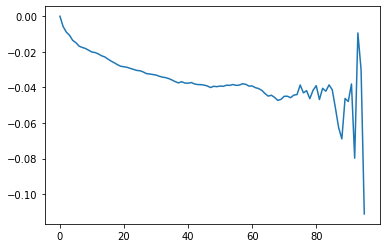

In [124]:
plt.plot(X, Y_means)
plt.show()

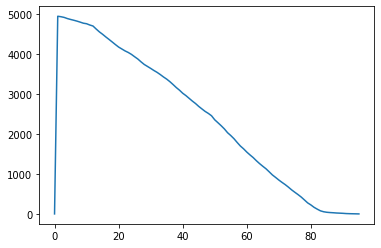

In [114]:
plt.plot(X, Y_counts)
plt.show()